In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import cv2

In [7]:
class CellImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.img_files = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.img_files[index])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(img)

        label = 1 if "parasite" in self.root_dir else 0
        return img, label


In [8]:
class CellImageClassifier(nn.Module):
    def __init__(self):
        super(CellImageClassifier, self).__init__()        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 12 * 12, 64)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(64, 2)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.pool2(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu3(out)
        out = self.pool3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu4(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out


In [9]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc


In [10]:
# Set up the root directory for the image data
root_dir = "E:/Document/M-Tech/M-Tech Class/2nd Trimester/Assignment/AI Lab/Assignment 7/Datasets/ch22m503/"

# Define the image transformations to apply
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create the dataset objects for the two classes
uninfected_data = CellImageDataset(root_dir + "/uninfected", transform=transform)
parasite_data = CellImageDataset(root_dir + "/parasite", transform=transform)

# Determine the number of samples in each class
num_uninfected = len(uninfected_data)
num_parasite = len(parasite_data)

# Determine the class weights to use for weighted sampling
class_weights = torch.Tensor([1.0, num_uninfected / num_parasite])

# Create the weighted sampler for the training data
sampler = torch.utils.data.WeightedRandomSampler(class_weights, num_samples=num_parasite+num_uninfected, replacement=True)

# Combine the two datasets into one and create the data loader using the weighted sampler
train_data = torch.utils.data.ConcatDataset([uninfected_data, parasite_data])
train_loader = DataLoader(train_data, batch_size=32, sampler=sampler)

# Define the CNN model and optimizer
model = CellImageClassifier()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the loss function with class weighting
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define the device to use for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model for 10 epochs
for epoch in range(10):
    epoch_loss, epoch_acc = train(model, train_loader, criterion, optimizer, device)
    print("Epoch {}: Loss = {:.4f}, Accuracy = {:.4f}".format(epoch+1, epoch_loss, epoch_acc))


Epoch 1: Loss = 0.3294, Accuracy = 1.0000
Epoch 2: Loss = 0.3133, Accuracy = 1.0000
Epoch 3: Loss = 0.3133, Accuracy = 1.0000
Epoch 4: Loss = 0.3133, Accuracy = 1.0000
Epoch 5: Loss = 0.3133, Accuracy = 1.0000
Epoch 6: Loss = 0.3133, Accuracy = 1.0000
Epoch 7: Loss = 0.3133, Accuracy = 1.0000
Epoch 8: Loss = 0.3133, Accuracy = 1.0000
Epoch 9: Loss = 0.3133, Accuracy = 1.0000
Epoch 10: Loss = 0.3133, Accuracy = 1.0000


In [47]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
#from keras import backend as K


import cv2
from PIL import Image
import numpy as np
#Import library 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,RocCurveDisplay,accuracy_score,make_scorer,roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


#Test GPU
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

def get_classification_metrics(actual_labels, predicted_labels):
    unique_labels = np.sort(np.unique(actual_labels))
    actual_labels_np = actual_labels
    predicted_labels_np = predicted_labels
    confusion_matrix = np.zeros((len(unique_labels), len(unique_labels)))
    classification_report = np.zeros((len(unique_labels), 5))    
    # Calculate confusion matrix
    for i in range(len(unique_labels)):
        for j in range(len(unique_labels)):
            confusion_matrix[i, j] = np.sum((actual_labels_np == unique_labels[i]) & (predicted_labels_np == unique_labels[j]))            
    # Calculate category accuracy
    print(confusion_matrix)
    category_accuracy = confusion_matrix.diagonal() / confusion_matrix.sum(axis=1)    
    weighted_acc = 0
    # Calculate metrics for each category
    for j in range(len(unique_labels)):        
        actual_label, predicted_label = (actual_labels_np == unique_labels[j]), (predicted_labels_np == unique_labels[j])
        true_positives, false_positives, false_negatives = np.sum(actual_label & predicted_label), np.sum(~actual_label & predicted_label), np.sum(actual_label & ~predicted_label)
        count = np.sum(actual_labels_np == unique_labels[j])
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        f1_score = 2 * (precision * recall) / (precision + recall) 
        classification_report[j, :] = np.round([precision, recall, f1_score, category_accuracy[j], count], round_precesion)
        weighted_acc += (f1_score * count)        
    weighted_acc = weighted_acc / len(actual_labels)    
    return weighted_acc, classification_report

os.chdir('E:\\Document\\M-Tech\\M-Tech Class\\2nd Trimester\\Assignment\\AI Lab\\Assignment 7\\Datasets\\ch22m503\\')

image_directory = 'E:\\Document\\M-Tech\\M-Tech Class\\2nd Trimester\\Assignment\\AI Lab\\Assignment 7\\Datasets\\ch22m503\\'
SIZE = 150
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
label = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.


parasitized_images = os.listdir(image_directory + 'parasite//')
for i, image_name in enumerate(parasitized_images):    #Remember enumerate method adds a counter and returns the enumerate object
    
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'parasite//' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(1)
        
uninfected_images = os.listdir(image_directory + 'uninfected//')
for i, image_name in enumerate(uninfected_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'uninfected//' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(0)
        
dataset = np.array(dataset)
label = np.array(label)
print("Dataset size is ", dataset.shape)
print("Label size is ", label.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.20, random_state = 0)
print("Train size is ", X_train.shape)
print("Test size is ", X_test.shape)

from keras.utils import normalize
X_train = normalize(X_train, axis=1)
X_test = normalize(X_test, axis=1)

Dataset size is  (492, 150, 150, 3)
Label size is  (492,)
Train size is  (393, 150, 150, 3)
Test size is  (99, 150, 150, 3)


Dataset size is  (492, 150, 150, 3)
Label size is  (492,)
Train size is  (393, 150, 150, 3)
Test size is  (99, 150, 150, 3)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 activation_35 (Activation)  (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 72, 72, 32)        9248      
                                                                 
 activation_36 (Activation)  (None, 72, 72, 32)        0         
                                                              

7/7 [==============================] - 2s 341ms/step - loss: 0.1463 - accuracy: 0.9593 - val_loss: 1.6721 - val_accuracy: 0.4949
Epoch 40/100
7/7 [==============================] - 2s 332ms/step - loss: 0.2032 - accuracy: 0.9135 - val_loss: 1.4949 - val_accuracy: 0.4747
Epoch 41/100
7/7 [==============================] - 2s 337ms/step - loss: 0.1335 - accuracy: 0.9771 - val_loss: 1.8531 - val_accuracy: 0.5152
Epoch 42/100
7/7 [==============================] - 2s 341ms/step - loss: 0.1167 - accuracy: 0.9644 - val_loss: 1.9575 - val_accuracy: 0.5051
Epoch 43/100
7/7 [==============================] - 2s 321ms/step - loss: 0.1618 - accuracy: 0.9364 - val_loss: 1.8052 - val_accuracy: 0.5152
Epoch 44/100
7/7 [==============================] - 2s 349ms/step - loss: 0.0740 - accuracy: 0.9822 - val_loss: 2.1851 - val_accuracy: 0.4949
Epoch 45/100
7/7 [==============================] - 3s 355ms/step - loss: 0.2759 - accuracy: 0.8880 - val_loss: 1.7398 - val_accuracy: 0.5152
Epoch 46/100
7/7 [=

Epoch 97/100
7/7 [==============================] - 2s 347ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 3.7449 - val_accuracy: 0.5253
Epoch 98/100
7/7 [==============================] - 2s 346ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 3.7593 - val_accuracy: 0.4949
Epoch 99/100
7/7 [==============================] - 2s 325ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 4.0632 - val_accuracy: 0.4848
Epoch 100/100
7/7 [==============================] - 2s 325ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 4.3265 - val_accuracy: 0.5051


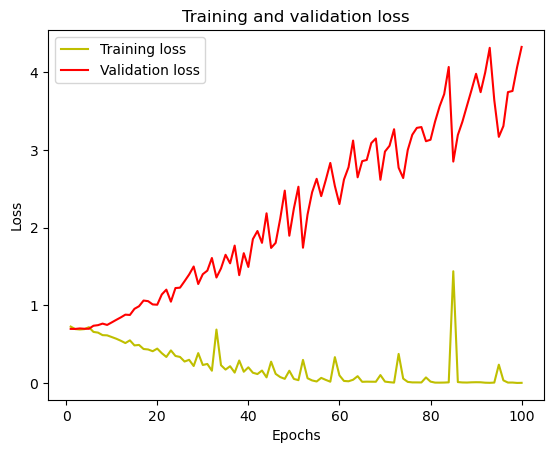

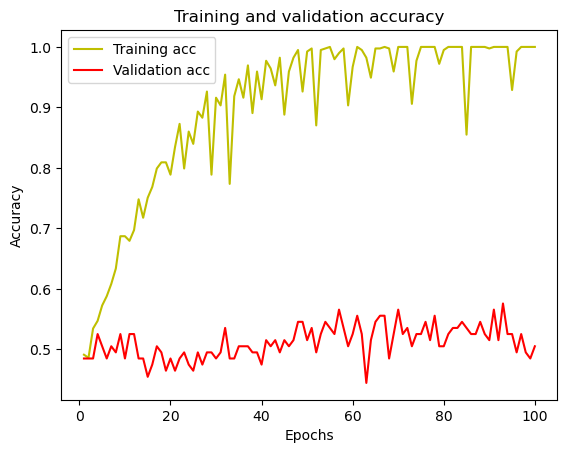

1/1 [==============================] - 0s 74ms/step
The prediction for this image is:  [[0.00153059]]
The actual label for this image is:  0
4/4 [==============================] - 0s 40ms/step - loss: 4.3265 - accuracy: 0.5051
Accuracy =  50.50504803657532 %
4/4 [==============================] - 0s 27ms/step
[[37 14]
 [30 18]]


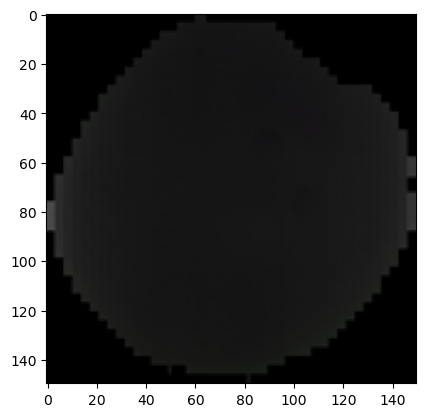

In [26]:


###Define the model

INPUT_SHAPE = (SIZE, SIZE, 3)   #change to (SIZE, SIZE, 3)


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))  


model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',             #also try adam
              metrics=['accuracy'])

print(model.summary()) 

history = model.fit(X_train, 
                         y_train, 
                         batch_size = 64, 
                         verbose = 1, 
                         epochs = 100,      
                         validation_data=(X_test,y_test),
                         shuffle = False
                     )


model.save('E:\\Document\\M-Tech\\M-Tech Class\\2nd Trimester\\Assignment\\AI Lab\\Assignment 7\\model_assignment7.h5')  

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

n=23  #Select the index of image to be loaded for testing
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", model.predict(input_img))
print("The actual label for this image is: ", y_test[n])


#We can load the trained model, so we don't have to train again for 300 epochs!
from keras.models import load_model
# load model
model = load_model('E:\\Document\\M-Tech\\M-Tech Class\\2nd Trimester\\Assignment\\AI Lab\\Assignment 7\\model_assignment7.h5')

#For 300 epochs, giving 82.5% accuracy

_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")


mythreshold=0.885


y_pred = (model.predict(X_test)>= mythreshold).astype(int)
cm=confusion_matrix(y_test, y_pred)  







In [45]:
weighted_acc, report = get_classification_metrics(y_test, np.ravel(y_pred))

print(f'Validation Accuracy {acc}')
print(f'Validation Weighted Accuracy {weighted_acc}')

df_result_train = pd.DataFrame(report, columns = ['Precision','Recall','F1 - Score', 'Accuracy - Category wise', 'Count - Category wise'])
display(df_result_train)


[[37. 14.]
 [30. 18.]]
Validation Accuracy 0.5050504803657532
Validation Weighted Accuracy 0.5412429378531074


,Precision,Recall,F1 - Score,Accuracy - Category wise,Count - Category wise
0,0.55,0.73,0.63,0.73,51.0
1,0.56,0.38,0.45,0.38,48.0


In [46]:
#### Another Solution

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
img_width = 64
img_height = 64

In [ ]:
datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)

In [ ]:
train_data_generator = datagen.flow_from_directory(directory='E:\\Document\\M-Tech\\M-Tech Class\\2nd Trimester\\Assignment\\AI Lab\\Assignment 7\\Datasets\\ch22m503',
                                                   target_size = (img_width, img_height),
                                                   class_mode = 'binary',
                                                   batch_size = 16,
                                                   subset = 'training'
                                                   )

In [ ]:
validation_data_generator = datagen.flow_from_directory(directory='E:\\Document\\M-Tech\\M-Tech Class\\2nd Trimester\\Assignment\\AI Lab\\Assignment 7\\Datasets\\ch22m503',
                                                   target_size = (img_width, img_height),
                                                   class_mode = 'binary',
                                                   batch_size = 16,
                                                   subset = 'validation')

In [ ]:
train_data_generator.labels

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3,3), input_shape = (img_width, img_height, 3), activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])  

In [ ]:
history = model.fit_generator(generator=train_data_generator,
                              steps_per_epoch = len(train_data_generator),
                              epochs = 20,
                              validation_data = validation_data_generator,
                              validation_steps = len(validation_data_generator))
history.history   